In [127]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
import bamboolib as bam
import plotly.express as px

In [128]:
val_cov = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/fmsan/results_4Feb21/results/results.sqlite3",
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/fmsan/results_4Feb21/plots/", 
    "Covid Data FMSAN"
)

val_cov_smsan = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/smsan/results/results.sqlite3",
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/cascade/covid_data/smsan/plots/", 
    "Covid Data SMSAN"
)

val_354 = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/ml/354/results/results.sqlite3", 
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/cluster_results/ml/354/plots/",
    "354"
)

val_tut = (
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/ng-tutorial/results/results.sqlite3", 
    "/Users/julia/Desktop/Masterarbeit/snakemake/data/ng-tutorial/plots/",
    "Ng-tutorial"
)

DB_PATH, PLOT_PATH, DATASET_NAME = val_cov

In [129]:
# convert sqlite database to pandas dataframe
con = sqlite3.connect(DB_PATH)

runs = pd.read_sql_query("SELECT * FROM run", con)

raxmls = pd.read_sql_query("SELECT * FROM raxmlng", con)
raxml_treesearch_trees = pd.read_sql_query("SELECT * FROM raxmltreesearchtree", con)
raxml_eval_trees = pd.read_sql_query("SELECT * FROM raxmlevaltree", con)

iqtrees = pd.read_sql_query("SELECT * FROM iqtree", con)
iqtree_treesearch_trees = pd.read_sql_query("SELECT * FROM iqtreetreesearchtree", con)
iqtree_eval_trees = pd.read_sql_query("SELECT * FROM iqtreeevaltree", con)

rfdist_raxml_treesearch_trees = pd.read_sql_query("SELECT * FROM rfdisttreesearchtree", con)
rfdist_raxml_eval_trees = pd.read_sql_query("SELECT * FROM rfdistevaltree", con)

Merge Run, Raxmlng and Iqtree

In [130]:
summary = runs.merge(raxmls, left_on="id", right_on="run_id", suffixes=("_run", "_raxml"))
summary = summary.merge(iqtrees, left_on="id_run", right_on="run_id", suffixes=("", "_iqtree"))
summary = summary.rename(columns={
    "best_treesearch_llh": "best_treesearch_llh_raxml",
    "best_evaluation_llh": "best_evaluation_llh_raxml",
    "treesearch_total_time": "treesearch_total_time_raxml",
    "id": "id_iqtree"
})
summary.treesearch_total_time_raxml = summary.treesearch_total_time_raxml.round().astype(int)
summary.treesearch_total_time_iqtree = summary.treesearch_total_time_iqtree.round().astype(int)

### Raxml
Merge summary with RaxmlTreesearchTrees and RaxmlEvalTrees

In [131]:
raxml_tree_summary = raxml_summary.merge(raxml_treesearch_trees, left_on="id_raxml", right_on="program_id")
raxml_tree_summary = raxml_tree_summary.merge(raxml_eval_trees, left_on="id", right_on="start_tree_id", suffixes=("_treesearch", "_eval"))
best_raxml = raxml_tree_summary.loc[raxml_tree_summary.is_best_eval == True]

best_raxml = best_raxml.rename(columns={
    "best_treesearch_llh_raxml": "max_llh_search",
    "best_evaluation_llh_raxml": "max_llh_eval",
    "treesearch_total_time_raxml": "total_time_search",
    "avg_rel_rfdist_treesearch": "avg_rfdist_search"
})

best_raxml.compute_time_eval = best_raxml.compute_time_eval.round().astype(int)

raxml_trees = summary.merge(raxml_treesearch_trees, left_on="id_raxml", right_on="program_id")

### Iqtree
Merge summary with IqtreeTreesearchTrees and IqtreeEvalTrees

In [132]:
iqtree_tree_summary = summary.merge(iqtree_treesearch_trees, left_on="id_iqtree", right_on="program_id")
iqtree_tree_summary = iqtree_tree_summary.merge(iqtree_eval_trees, left_on="id", right_on="start_tree_id", suffixes=("_treesearch", "_eval"))
best_iqtree = iqtree_tree_summary.loc[iqtree_tree_summary.is_best_eval == True]

best_iqtree = best_iqtree.rename(columns={
    "best_treesearch_llh_iqtree": "max_llh_search",
    "best_evaluation_llh_iqtree": "max_llh_eval",
    "treesearch_total_time_iqtree": "total_time_search",
})
best_iqtree.compute_time_eval = best_iqtree.compute_time_eval.round().astype(int)

iqtree_trees = summary.merge(iqtree_treesearch_trees, left_on="id_iqtree", right_on="program_id")

## Plot summary tables of all runs

In [133]:
def dataset_summary_table(df, progr_name, cols_to_use=None, col_width=2.3, row_height=0.625, font_size=16, bbox=[0, 0, 1, 1]):
    data = df
    if cols_to_use:
        data = data[cols_to_use]
    
    size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
    fig, ax = plt.subplots(figsize=size)
    ax.set_title(f"Run summary for {progr_name}")
    ax.axis('off')

    table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns)

    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    plt.tight_layout() 
    #fig.savefig(PLOT_PATH + f"dataset_summary_{progr_name}_table.pdf", format="pdf")
    fig.savefig(PLOT_PATH + f"dataset_summary_{progr_name}_table.svg", format="svg")


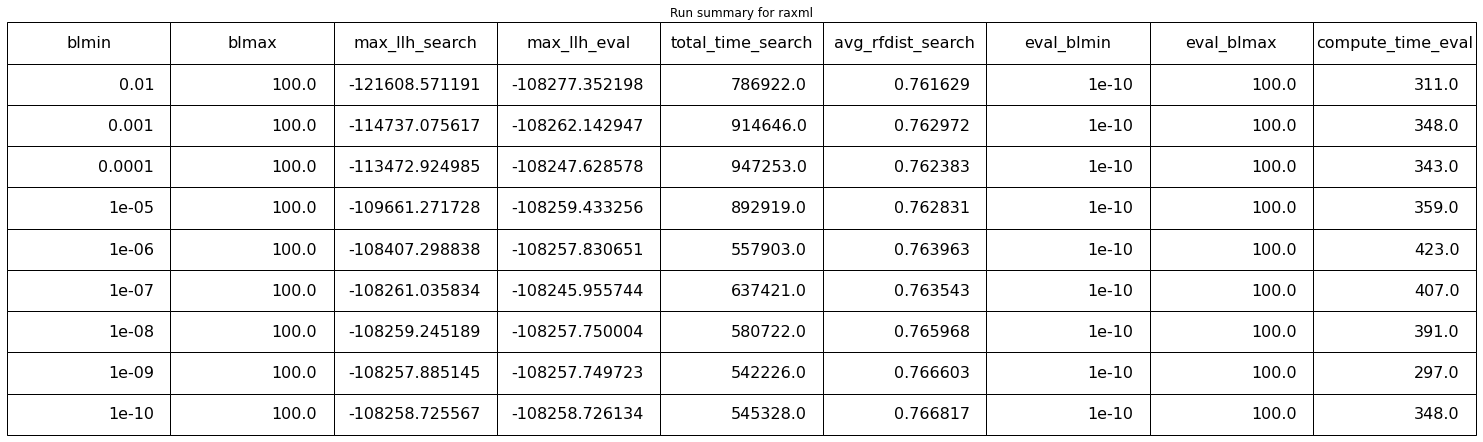

In [134]:
cols_to_plot = [
    "blmin", 
    "blmax", 
    "max_llh_search", 
    "max_llh_eval",
    "total_time_search",
    "avg_rfdist_search",
    "eval_blmin",
    "eval_blmax",
    "compute_time_eval"
]
dataset_summary_table(best_raxml, "raxml", cols_to_plot)

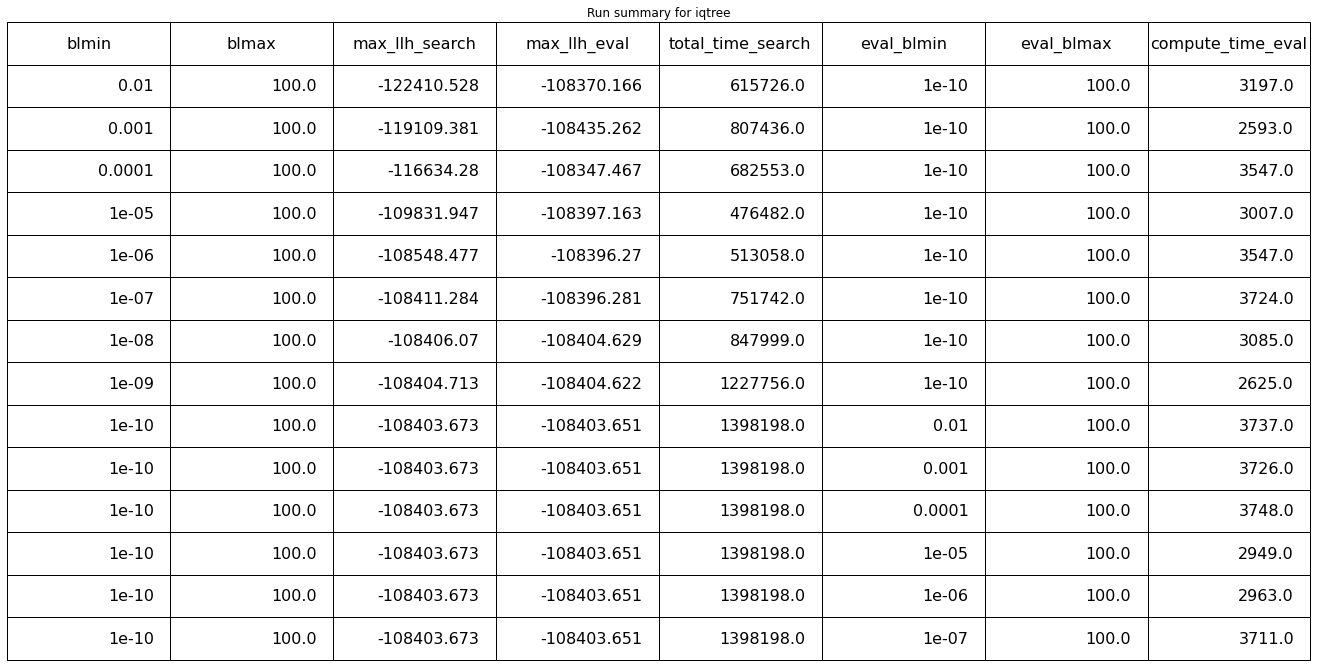

In [135]:
cols_to_plot = [
    "blmin", 
    "blmax", 
    "max_llh_search", 
    "max_llh_eval",
    "total_time_search",
    "eval_blmin",
    "eval_blmax",
    "compute_time_eval"
]
dataset_summary_table(best_iqtree, "iqtree", cols_to_plot)

## Llh plots

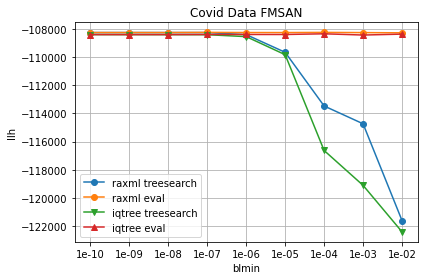

In [136]:
def plot_llhs(df):
    ax = plt.gca()
    ax.set_xlabel("blmin")    
    df.plot(style="o-", x="blmin", y="best_treesearch_llh_raxml", label="raxml treesearch", ax=ax, logx=True, xticks=df["blmin"], xlabel="blmin", ylabel="llh", title=DATASET_NAME)
    df.plot(style="o-", x="blmin", y="best_evaluation_llh_raxml", label="raxml eval", ax=ax)
    df.plot(style="v-", x="blmin", y="best_treesearch_llh_iqtree", label="iqtree treesearch", ax=ax)
    df.plot(style="^-", x="blmin", y="best_evaluation_llh_iqtree", label="iqtree eval", ax=ax)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    plt.grid(True)
    plt.tight_layout() 
    fig = ax.get_figure()
    #fig.savefig(PLOT_PATH + "llhs.pdf", format="pdf")
    fig.savefig(PLOT_PATH + "llhs.svg", format="svg")


plot_llhs(summary)

# Runtime plots

## Total time

In [148]:
def plot_total_time(df, time_col_name, time_name, progr_name, notes=None):
    ax = plt.gca()
    ax.set_xlabel("blmin")
    df.plot(kind="scatter", x="blmin", y=time_col_name, ax=ax, logx=True, xticks=df["blmin"], xlabel="blmin", ylabel="total runtime (s)", figsize=(10,5))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
    plt.grid(True)
    plt.title(f"Total runtime for {progr_name} {time_name} {notes}") 
    plt.tight_layout() 
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + f"runtime_{time_name}_{progr_name}.svg", format="svg")  

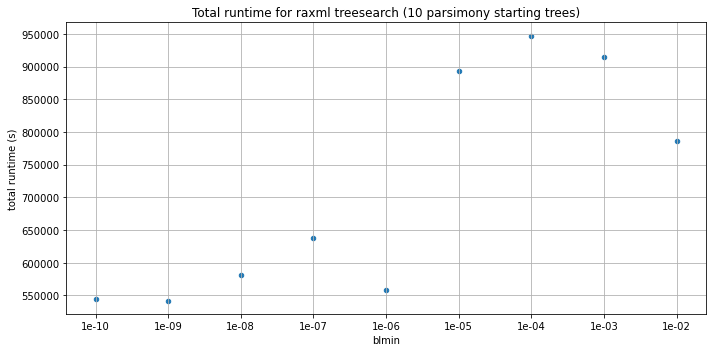

In [149]:
plot_total_time(best_raxml, "total_time_search", "treesearch", "raxml", notes="(10 parsimony starting trees)")

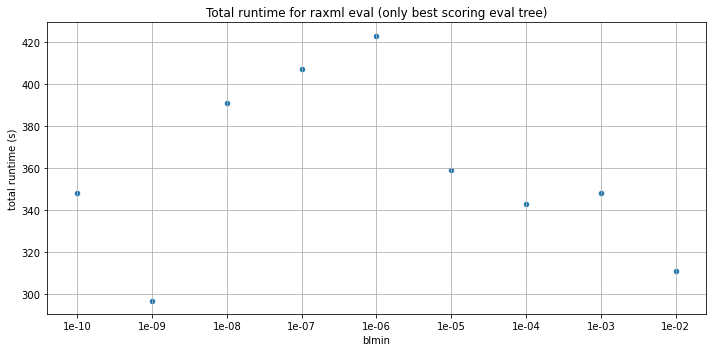

In [150]:
plot_total_time(best_raxml, "compute_time_eval", "eval", "raxml", notes="(only best scoring eval tree)")

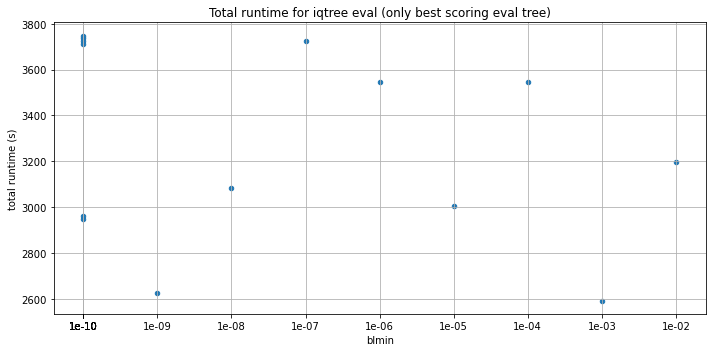

In [151]:
plot_total_time(best_iqtree, "compute_time_eval", "eval", "iqtree", notes="(only best scoring eval tree)")

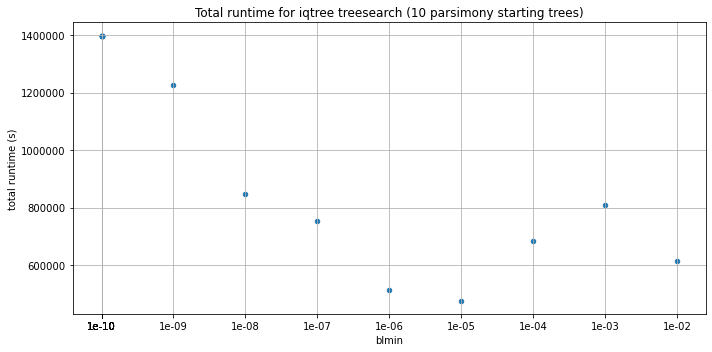

In [152]:
plot_total_time(best_iqtree, "total_time_search", "treesearch", "iqtree", notes="(10 parsimony starting trees)")

## Total time relative to reference time

In [153]:
def plot_runtime_relative_to_reference(df, time_col_to_plot, time_name, reference_time, reference_time_name, progr_name, show_progr_name_in_title=True, color=None):
    ax = plt.gca()
    plt.xscale("log")
    
    # calculate times relative to reference_time
    times = list(df[time_col_to_plot])
    rel_times = [t / reference_time for t in times]
    
    ax.scatter(x=list(df["blmin"]), y=rel_times, label=progr_name, c=color)
    ax.set_xlabel("blmin")
    ax.set_ylabel("relative runtime")
    ax.legend()
    ax.set_xticks(list(df["blmin"]))
    ax.set_xticklabels(list(df["blmin"]))
    ax.axhline(y=1, linewidth=1, color='k')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    
    if not show_progr_name_in_title:
        progr_name = ""
    plt.grid(True)
    plt.title(f"Relative runtime for {progr_name} {time_name} with respect to \n runtime for {reference_time_name} ({reference_time} seconds)")
    plt.tight_layout() 
    
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + f"runtime_{time_name}_{progr_name}_reference_time_{reference_time_name}.svg", format="svg")
    

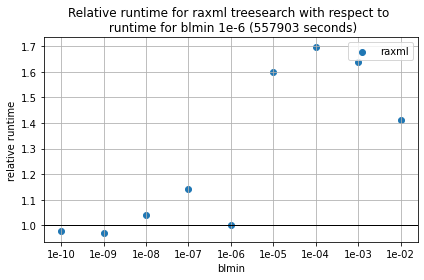

In [154]:
ref_time_raxml = best_raxml.loc[best_raxml.blmin == 1e-6].total_time_search.item()
plot_runtime_relative_to_reference(best_raxml, "total_time_search", "treesearch", ref_time_raxml, "blmin 1e-6", "raxml")

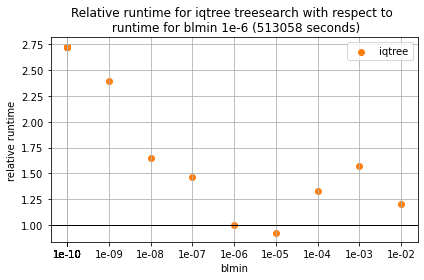

In [157]:
ref_time_iqtree = best_iqtree.loc[best_iqtree.blmin == 1e-6].total_time_search.item()
plot_runtime_relative_to_reference(best_iqtree, "total_time_search", "treesearch", ref_time_iqtree, "blmin 1e-6", "iqtree", color="#ff7f0e")

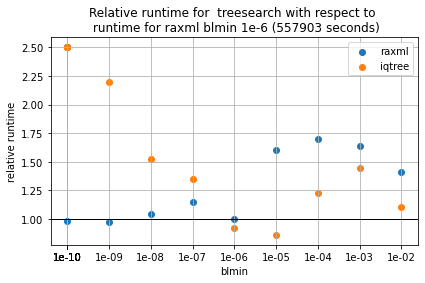

In [158]:
plot_runtime_relative_to_reference(best_raxml, "total_time_search", "treesearch", ref_time_raxml, "raxml blmin 1e-6", "raxml", show_progr_name_in_title=False)
plot_runtime_relative_to_reference(best_iqtree, "total_time_search", "treesearch", ref_time_raxml, "raxml blmin 1e-6", "iqtree", show_progr_name_in_title=False)

## Violin runtime plots per tree

In [163]:
def violin_plots_runtime(x, y, xlabel, color, time_name, progr_name):
    plt.figure(figsize=(20,7))
    ax = sns.violinplot(x=x, y=y, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("cpu time per tree (s)")
    ax.grid(axis="y")
    plt.title(f"Runtime {progr_name} {time_name} trees")
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + f"violin_runtime_{time_name}_{progr_name}.svg", format="svg")

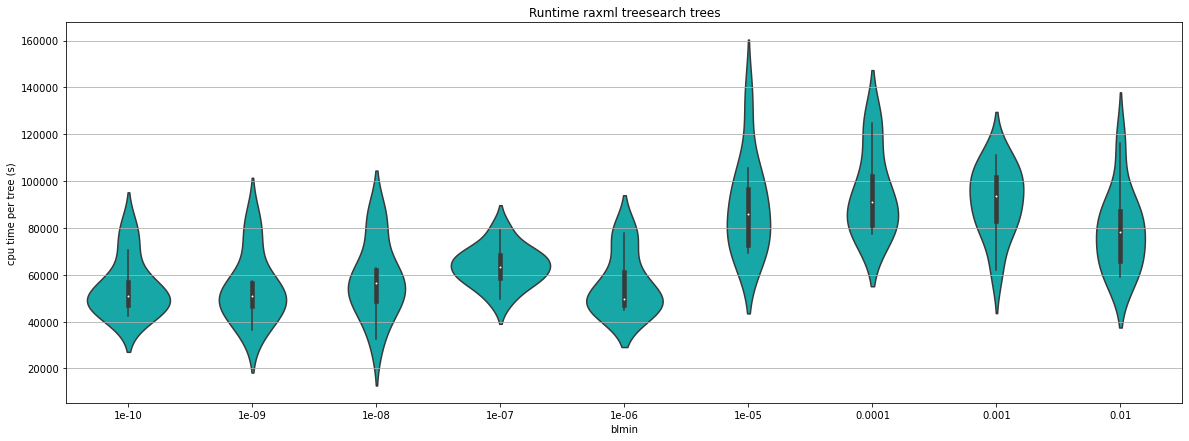

In [164]:
violin_plots_runtime(x=raxml_trees["blmin"], y=raxml_trees["compute_time"], xlabel="blmin", color="c", time_name="treesearch", progr_name="raxml")

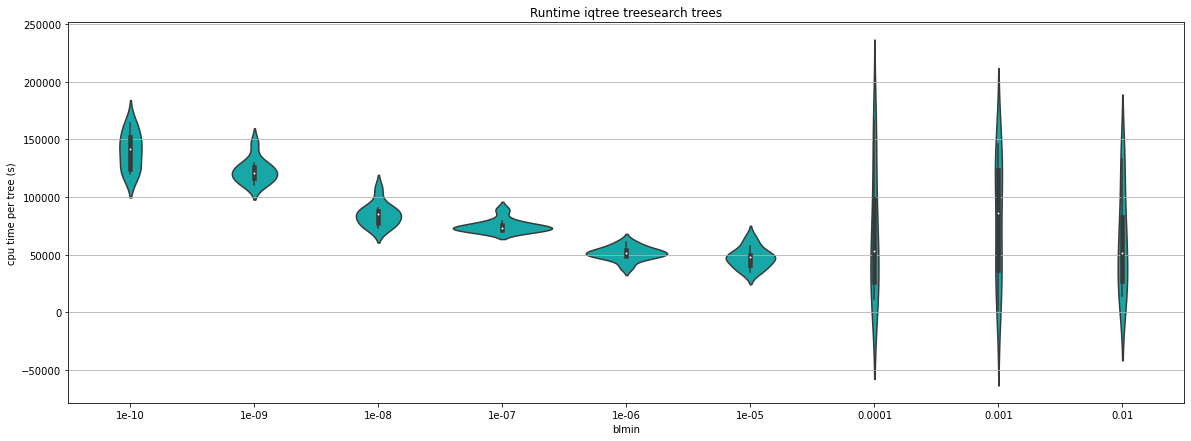

In [165]:
violin_plots_runtime(x=iqtree_trees["blmin"], y=iqtree_trees["compute_time"], xlabel="blmin", color="c", time_name="treesearch", progr_name="iqtree")


In [170]:
def boxplots_runtime(df, groupby, xlabel, time_name, progr_name):
    ax = df.boxplot(by=groupby,figsize=(20,7), boxprops=dict(linestyle='-', linewidth=1), medianprops=dict(linestyle='-', linewidth=1.5), whiskerprops=dict(linestyle='-', linewidth=1.5),)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Compute time per tree (s)")
    plt.suptitle("")
    plt.title(f"Runtime {progr_name} {time_name} trees")
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + f"boxplot_runtime_{time_name}_{progr_name}.svg", format="svg")

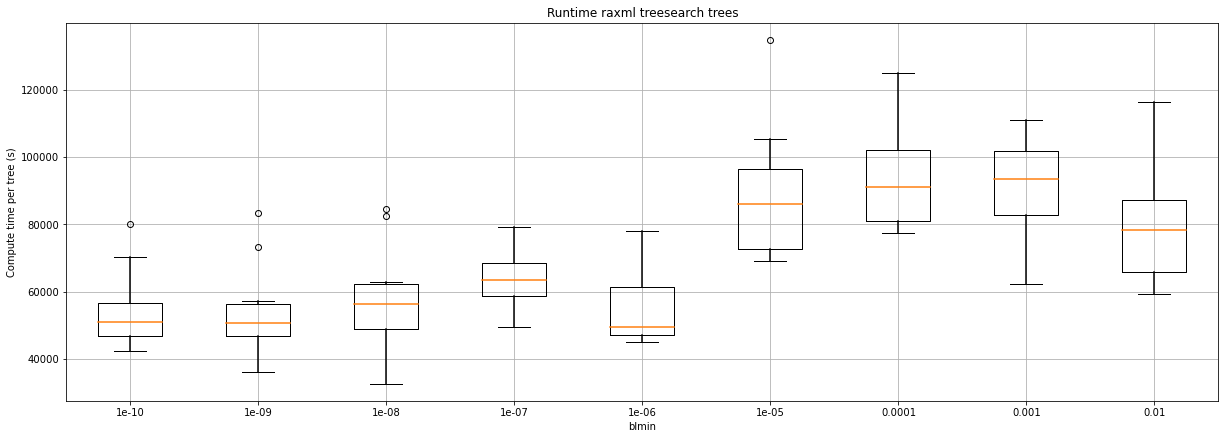

In [171]:
trees = raxml_trees[["blmin", "compute_time"]]
boxplots_runtime(trees, groupby="blmin", xlabel="blmin", time_name="treesearch", progr_name="raxml")

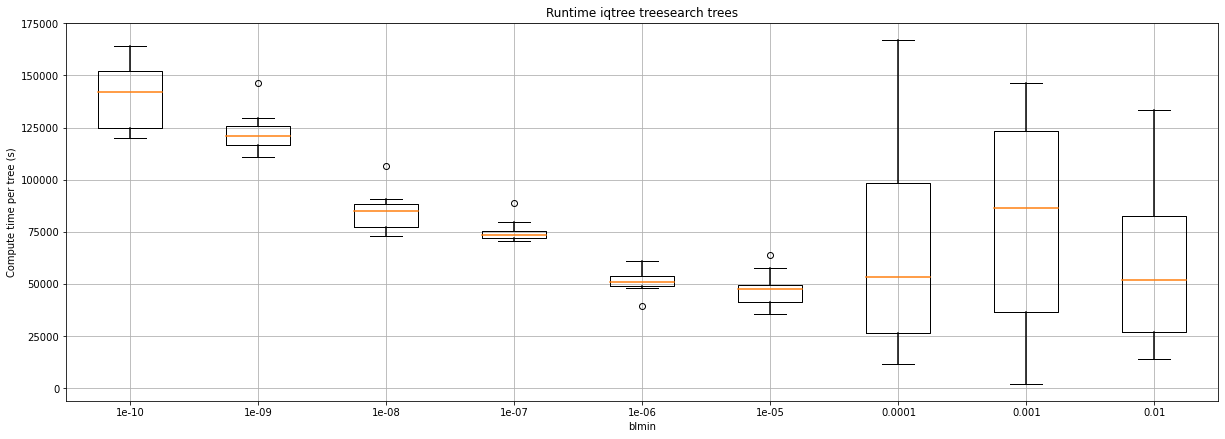

In [172]:
trees = iqtree_trees[["blmin", "compute_time"]]
boxplots_runtime(trees, groupby="blmin", xlabel="blmin", time_name="treesearch", progr_name="iqtree")

# RF Distances

In [104]:
def get_blmin_for_eval_tree_id(eval_tree_id, progr_name):
    if progr_name == "raxml":
        eval_trees = raxml_eval_trees
        trees = raxml_treesearch_trees
        progr = raxmls
    elif progr_name == "iqtree":
        eval_trees = iqtree_eval_trees
        trees = iqtree_treesearch_trees
        progr = iqtrees
    eval_tree = eval_trees.loc[eval_trees.id == eval_tree_id]
    start_tree_id = eval_tree.start_tree_id.item()
    start_tree = trees.loc[trees.id == start_tree_id]
    progr_id = start_tree.program_id.item()
    program = progr.loc[progr.id == progr_id]
    run_id = program.run_id.item()
    run = runs.loc[runs.id == run_id]
    return run.blmin.item()

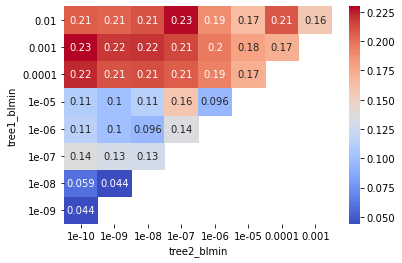

In [173]:
tree1_ids = []
tree2_ids = []
tree1_blmins = []
tree2_blmins = []
normalized_rf_distances = []
for idx, row in rfdist_raxml_eval_trees.iterrows():
    tree1_ids.append(row.tree1_id)
    tree1_blmins.append(get_blmin_for_eval_tree_id(row.tree1_id, "raxml"))
    tree2_ids.append(row.tree2_id)
    tree2_blmins.append(get_blmin_for_eval_tree_id(row.tree2_id, "raxml"))
    normalized_rf_distances.append(row.normalized_rfdist)

d = {
    "tree1_id": tree1_ids,
    "tree2_id": tree2_ids,
    "tree1_blmin": tree1_blmins,
    "tree2_blmin": tree2_blmins,
    "normalized_rfdist": normalized_rf_distances,
}
df = pd.DataFrame(data=d)

data = df.pivot("tree1_blmin", "tree2_blmin", "normalized_rfdist")

ax = plt.gca()
hmap = sns.heatmap(data, annot=True, cmap="coolwarm", ax=ax)
ax.invert_yaxis()


fig = ax.get_figure()

#fig.savefig(PLOT_PATH + "rfdist_best_eval_trees.pdf", format="pdf", bbox_inches="tight") 
fig.savefig(PLOT_PATH + "rfdist_best_eval_trees.svg", format="svg", bbox_inches="tight") 

In [177]:
def plot_eval_llhs_for_varying_blmin(treesearch_blmin, progr_name):
    if progr_name == "raxml":
        program = raxmls
        trees = raxml_treesearch_trees
        eval_trees = raxml_eval_trees
    elif progr_name == "iqtree":
        program = iqtrees
        trees = iqtree_treesearch_trees
        eval_trees = iqtree_eval_trees
        
    r_id = runs.loc[runs.blmin == treesearch_blmin].id.item()
    program_id = program.loc[program.run_id == r_id].id.item()
    best_tree_id = trees.loc[(trees.program_id == program_id) & (trees.is_best == True)].id.item()
    
    eval_t = eval_trees.loc[(eval_trees.start_tree_id == best_tree_id)]
    eval_t = eval_t[["llh", "is_best", "eval_blmin"]]

    ax = plt.gca()
    ax.set_xlabel("eval_blmin") 
    eval_t.plot(style="o-", x="eval_blmin", y="llh", ax=ax, logx=True, xticks=eval_t["eval_blmin"], xlabel="eval_blmin", ylabel="llh", label=f"{progr_name}_llh")
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    
    plt.grid(True)
    plt.title(f"{progr_name} eval llhs for treesearch blmin {treesearch_blmin}")

    plt.tight_layout() 
    fig = ax.get_figure()
    fig.savefig(PLOT_PATH + f"{progr_name}_eval_llhs_for_start_blmin_{treesearch_blmin}.svg", format="svg")


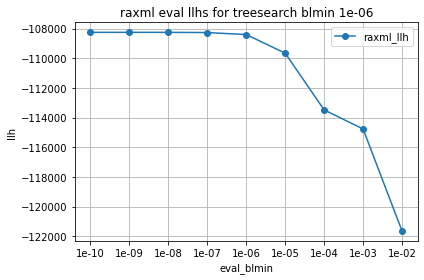

In [178]:
plot_eval_llhs_for_varying_blmin(1e-6, "raxml")

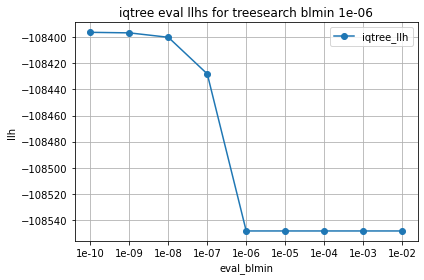

In [179]:
plot_eval_llhs_for_varying_blmin(1e-6, "iqtree")